In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 加载数据
data = pd.read_csv('/Users/lyndseyxia/Desktop/NYU/capstone/fall/SP600_AdjClose_Volume_Return.csv')
data['Date'] = pd.to_datetime(data['Date'])  # 确保日期格式正确
data.set_index('Date', inplace=True)

# 预处理数据，假设 'Adj Close' 是股票的收盘价
data['Daily Return'] = data['Adj Close'].pct_change()
data['Rolling Volatility'] = data['Daily Return'].rolling(window=20).std()
delta = data['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# 清除缺失值
data.dropna(inplace=True)

# 特征选择
features = data[['Volume', 'Daily Return', 'Rolling Volatility', 'RSI']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 应用 PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data = principal_components, columns=['PC1', 'PC2'])

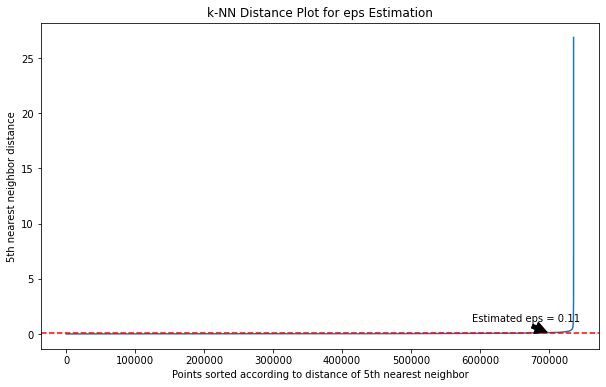

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 假设 scaled_features 是已经标准化的特征数据
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# 排序距离
sorted_distances = np.sort(distances, axis=0)[:, 1]  # 选择第二小的距离
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title("k-NN Distance Plot for eps Estimation")
plt.xlabel("Points sorted according to distance of 5th nearest neighbor")
plt.ylabel("5th nearest neighbor distance")

# 添加水平线来估计 eps
eps_estimate = sorted_distances[int(0.95 * len(sorted_distances))]  # 假设拐点在95%的位置
plt.axhline(y=eps_estimate, color='r', linestyle='--')
plt.annotate(f'Estimated eps = {eps_estimate:.2f}', xy=(0.95 * len(sorted_distances), eps_estimate), xytext=(0.8 * len(sorted_distances), eps_estimate + 1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.show()


In [3]:
# 分批应用 DBSCAN
def batch_dbscan(data, batch_size=1000, eps=0.8, min_samples=10):
    n_samples = data.shape[0]
    labels = np.full(n_samples, -1, dtype=int)  # 初始化所有点为噪声
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch = data[start:end]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        batch_labels = dbscan.fit_predict(batch)
        
        # 更新标签，需要处理边界点的标签
        labels[start:end] = batch_labels
    
    return labels

# 执行分批 DBSCAN
labels = batch_dbscan(pca_df.values)

# 将标签添加到原始数据框
data['Cluster'] = labels

# 分析和可视化结果
print(data['Cluster'].value_counts())

 0    693416
-1     33471
 1      6483
 4       759
 3       621
 6       505
 2       222
 5        32
 8        16
 9        10
 7        10
Name: Cluster, dtype: int64


In [7]:
# 初始参数
eps_values = [0.5, 0.4, 0.3, 0.2, 0.1]  # 逐步减小eps
min_samples_values = [10, 8, 5]  # 逐步减小min_samples

# 测试不同的参数组合
for eps in eps_values:
    for min_samples in min_samples_values:
        labels = batch_dbscan(pca_df.values, eps=eps, min_samples=min_samples)
        data['Cluster'] = labels
        anomaly_count = (data['Cluster'] == -1).sum()
        print(f"EPS: {eps}, Min Samples: {min_samples}, Anomalies: {anomaly_count}")


EPS: 0.5, Min Samples: 10, Anomalies: 14919
EPS: 0.5, Min Samples: 8, Anomalies: 13119
EPS: 0.5, Min Samples: 5, Anomalies: 9755
EPS: 0.4, Min Samples: 10, Anomalies: 21284
EPS: 0.4, Min Samples: 8, Anomalies: 18325
EPS: 0.4, Min Samples: 5, Anomalies: 13430
EPS: 0.3, Min Samples: 10, Anomalies: 33471
EPS: 0.3, Min Samples: 8, Anomalies: 28639
EPS: 0.3, Min Samples: 5, Anomalies: 20548
EPS: 0.2, Min Samples: 10, Anomalies: 61099
EPS: 0.2, Min Samples: 8, Anomalies: 52256
EPS: 0.2, Min Samples: 5, Anomalies: 37317
EPS: 0.1, Min Samples: 10, Anomalies: 162242
EPS: 0.1, Min Samples: 8, Anomalies: 138018
EPS: 0.1, Min Samples: 5, Anomalies: 96975


In [4]:
data

,Adj Close,Volume,Ticker,Return,Daily Return,Rolling Volatility,RSI,Cluster
Date,,,,,,,,
2019-10-28,151.906799,978800,AAP,0.005134,0.005134,0.013407,81.166427,0
2019-10-29,150.026291,657500,AAP,-0.012379,-0.012379,0.013432,73.267822,0
2019-10-30,149.679413,721600,AAP,-0.002312,-0.002312,0.012082,69.851578,0
2019-10-31,148.319275,826600,AAP,-0.009087,-0.009087,0.011429,60.272637,0
2019-11-01,150.455353,677800,AAP,0.014402,0.014402,0.011821,68.582663,0
...,...,...,...,...,...,...,...,...
2024-09-23,34.169998,1511400,ZWS,-0.019231,-0.019231,0.024073,66.179743,0
2024-09-24,34.669998,988700,ZWS,0.014633,0.014633,0.024107,72.945177,0
2024-09-25,34.700001,1020700,ZWS,0.000865,0.000865,0.024079,75.087693,0


In [5]:
# 筛选出标记为异常的数据点
anomalies = data[data['Cluster'] == -1].copy()

# 确保日期列为DataFrame的一部分以便导出
anomalies.reset_index(inplace=True)

# 选择导出的列
anomalies_to_export = anomalies[['Date', 'Ticker', 'Adj Close', 'Volume', 'Daily Return', 'Rolling Volatility', 'RSI']]

# 将CSV文件保存到临时目录或其他已知的可写目录
anomalies_to_export.to_csv('/Users/lyndseyxia/Desktop/NYU/capstone/fall/anomalies_dbscan_pca.csv', index=False)

In [6]:
# 加载CSV文件
anomalies_df = pd.read_csv('/Users/lyndseyxia/Desktop/NYU/capstone/fall/anomalies_dbscan_pca.csv')

# 打印行数和列数
print("Number of rows:", anomalies_df.shape[0])
print("Number of columns:", anomalies_df.shape[1])

# 打印列名以查看具体有哪些列
print("Columns:", anomalies_df.columns.tolist())


Number of rows: 33471
Number of columns: 7
Columns: ['Date', 'Ticker', 'Adj Close', 'Volume', 'Daily Return', 'Rolling Volatility', 'RSI']


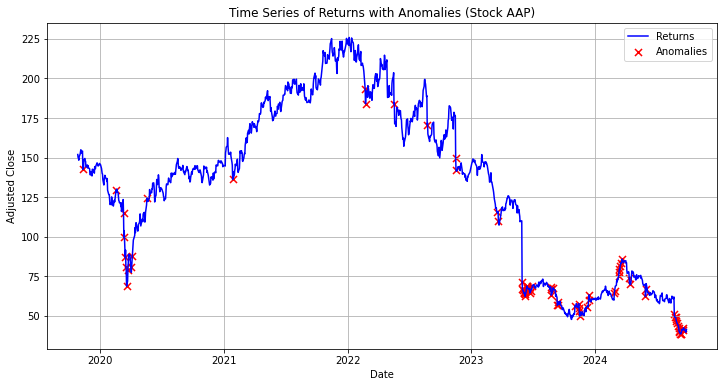

In [4]:
# 可视化特定股票
stock_index = 'AAP'  # 选择一个股票标识符，这里以苹果公司为例
selected_stock = data[data['Ticker'] == stock_index]

# 绘制时间序列图，展示正常点和异常点
plt.figure(figsize=(12, 6))
plt.plot(selected_stock.index, selected_stock['Adj Close'], label='Returns', color='blue')
anomalies = selected_stock[selected_stock['Cluster'] == -1]
plt.scatter(anomalies.index, anomalies['Adj Close'], color='red', label='Anomalies', marker='x', s=50)

# 设置图表标题和标签
plt.title(f'Time Series of Returns with Anomalies (Stock {stock_index})')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


In [8]:
# 假设 'Ticker' 是你的股票标识符列
print(data['Ticker'].unique())

['AAP' 'AAT' 'ABCB' 'ABG' 'ABM' 'ABR' 'ACA' 'ACIW' 'ACLS' 'ADEA' 'ADMA'
 'ADNT' 'ADUS' 'AEIS' 'AEO' 'AGO' 'AGYS' 'AHCO' 'AHH' 'AIN' 'AIR' 'AKR'
 'AL' 'ALEX' 'ALG' 'ALGT' 'ALK' 'ALKS' 'ALRM' 'AMBC' 'AMN' 'AMPH' 'AMR'
 'AMSF' 'AMWD' 'ANDE' 'ANIP' 'AORT' 'AOSL' 'APAM' 'APLE' 'APOG' 'ARCB'
 'ARCH' 'ARI' 'ARLO' 'AROC' 'ARR' 'ASIX' 'ASO' 'ASTE' 'ASTH' 'ATEN' 'ATGE'
 'ATI' 'AUB' 'AVA' 'AVAV' 'AVNS' 'AWI' 'AWR' 'AX' 'AXL' 'AZZ' 'B' 'BANC'
 'BANF' 'BANR' 'BCC' 'BCPC' 'BDN' 'BFH' 'BFS' 'BGC' 'BGS' 'BHE' 'BHLB'
 'BJRI' 'BKE' 'BKU' 'BL' 'BLFS' 'BLMN' 'BMI' 'BOH' 'BOOT' 'BOX' 'BRC'
 'BRKL' 'BSIG' 'BTU' 'BXMT' 'CABO' 'CAKE' 'CAL' 'CALM' 'CALX' 'CARG'
 'CARS' 'CASH' 'CATY' 'CBRL' 'CBU' 'CCOI' 'CCRN' 'CCS' 'CEIX' 'CENT'
 'CENTA' 'CENX' 'CERT' 'CEVA' 'CFFN' 'CHCO' 'CHEF' 'CHUY' 'CLB' 'CLW'
 'CMA' 'CNK' 'CNMD' 'CNS' 'CNSL' 'CNXN' 'COHU' 'COLL' 'COOP' 'CORT' 'CPF'
 'CPK' 'CPRX' 'CRC' 'CRK' 'CRS' 'CRSR' 'CRVL' 'CSGS' 'CSR' 'CSWI' 'CTKB'
 'CTRE' 'CTS' 'CUBI' 'CVBF' 'CVCO' 'CVI' 'CWEN' 'CWK' 'CWT' 'CXM' 'CX

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# 假定data已经被加载和预处理
# 假定PCA和DBSCAN已经应用于data
# 假定pca_df是PCA后的DataFrame，data['Cluster']是DBSCAN的结果

# 选择正常点和异常点
normal_points = pca_df[data['Cluster'] >= 0]  # 修改为合适的正常点条件
anomaly_points = pca_df[data['Cluster'] == -1]

# 计算正常点的凸包
hull = ConvexHull(normal_points)
hull_vertices = normal_points.iloc[hull.vertices]

# 绘图
plt.figure(figsize=(12, 8))
plt.scatter(normal_points['PC1'], normal_points['PC2'], c='blue', label='Normal Points')
plt.scatter(anomaly_points['PC1'], anomaly_points['PC2'], c='red', label='Anomalies')
# 绘制凸包
for simplex in hull.simplices:
    plt.plot(normal_points.iloc[simplex, 0], normal_points.iloc[simplex, 1], 'k-')

# 凸包顶点
plt.plot(hull_vertices['PC1'], hull_vertices['PC2'], 'o', markersize=10,
         markerfacecolor='green', label='Convex Hull Vertices')

plt.title('PCA Results with DBSCAN Clusters and Convex Hull')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# 统计凸包内外的异常点
inside_hull = np.array([hull.find_simplex(anomaly_points) >= 0])
inside_count = np.sum(inside_hull)
outside_count = len(anomaly_points) - inside_count
print(f"Anomalies inside the hull: {inside_count}")
print(f"Anomalies outside the hull: {outside_count}")


/var/folders/rb/zrly9w1j48x9pv560021136h0000gn/T/ipykernel_16322/2948350169.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  normal_points = pca_df[data['Cluster'] >= 0]  # 修改为合适的正常点条件
/var/folders/rb/zrly9w1j48x9pv560021136h0000gn/T/ipykernel_16322/2948350169.py:14: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  normal_points = pca_df[data['Cluster'] >= 0]  # 修改为合适的正常点条件


ValueError: cannot reindex on an axis with duplicate labels

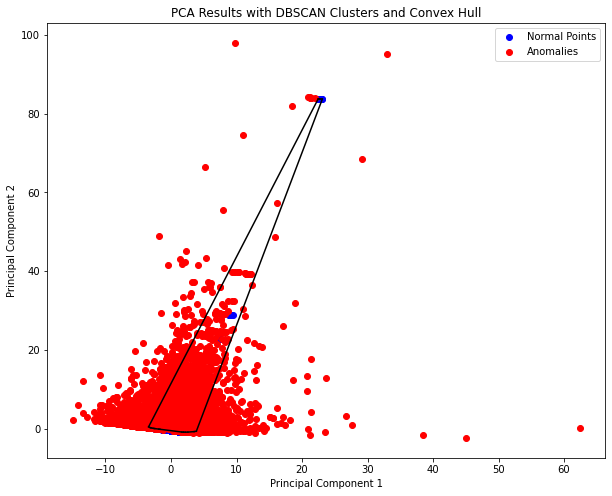

AttributeError: 'ConvexHull' object has no attribute 'find_simplex'

In [6]:
# 确保 'Cluster' 标签被加到 pca_df
pca_df['Cluster'] = labels  # 添加DBSCAN结果到PCA结果DataFrame中

# 筛选正常点和异常点
normal_points = pca_df[pca_df['Cluster'] >= 0]  # 假定正常点的cluster标签>=0
anomaly_points = pca_df[pca_df['Cluster'] == -1]  # 假定异常点的cluster标签为-1

# 计算正常点的凸包
hull = ConvexHull(normal_points[['PC1', 'PC2']])  # 仅用PCA主成分计算凸包

# 绘制正常点、异常点和凸包
plt.figure(figsize=(10, 8))
plt.scatter(normal_points['PC1'], normal_points['PC2'], c='blue', label='Normal Points')
plt.scatter(anomaly_points['PC1'], anomaly_points['PC2'], c='red', label='Anomalies')
for simplex in hull.simplices:
    plt.plot(normal_points.iloc[simplex, 0], normal_points.iloc[simplex, 1], 'k-')

plt.title('PCA Results with DBSCAN Clusters and Convex Hull')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# 统计凸包内外的异常点数量
inside_hull = np.array([hull.find_simplex(anomaly_points[['PC1', 'PC2']]) >= 0])
inside_count = np.sum(inside_hull)
outside_count = len(anomaly_points) - inside_count
print(f"Anomalies inside the hull: {inside_count}")
print(f"Anomalies outside the hull: {outside_count}")


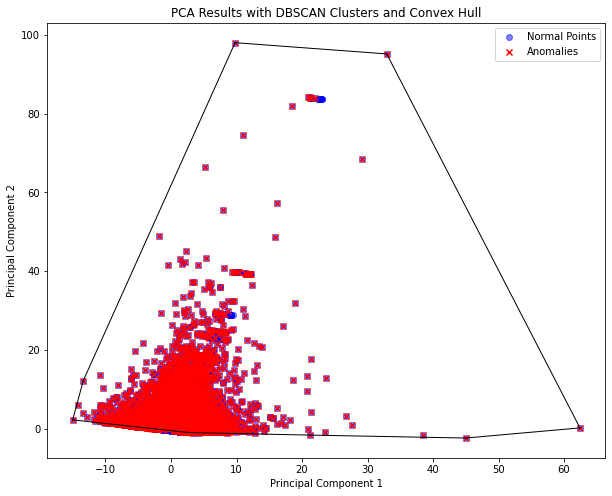

In [8]:
from scipy.spatial import ConvexHull

# 将PCA结果和聚类标签合并到一个新的DataFrame
pca_df['Cluster'] = labels

# 筛选出异常点
anomalies = pca_df[pca_df['Cluster'] == -1]

# 绘制所有点的散点图
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', alpha=0.5, label='Normal Points')
plt.scatter(anomalies['PC1'], anomalies['PC2'], c='red', marker='x', label='Anomalies')

# 如果异常点足够多，绘制凸包
if len(anomalies) > 2:
    hull = ConvexHull(anomalies[['PC1', 'PC2']])
    for simplex in hull.simplices:
        plt.plot(anomalies.iloc[simplex, 0], anomalies.iloc[simplex, 1], 'k-', linewidth=1)

plt.title('PCA Results with DBSCAN Clusters and Convex Hull')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [9]:
# 创建空的DataFrame来存储质心
centroids = pd.DataFrame(columns=['PC1', 'PC2'])

# 筛选出有效的簇
for cluster in set(labels):
    if cluster != -1:  # 排除噪声点
        cluster_points = pca_df[pca_df['Cluster'] == cluster]
        centroid = cluster_points.mean()
        centroids = centroids.append(centroid, ignore_index=True)

print(centroids)


        PC1       PC2  Cluster
0 -0.015426 -0.098342      0.0
1  0.234169  1.091318      1.0
2  -0.07278  1.706071      2.0
3  0.137345  0.319057      3.0
4 -0.118238 -0.163565      4.0
5  0.811133  2.834103      5.0
6  0.261094  0.310152      6.0
7 -1.728804   3.14871      7.0
8 -1.302537  3.592197      8.0
9  0.994953  4.245796      9.0


/var/folders/rb/zrly9w1j48x9pv560021136h0000gn/T/ipykernel_16168/365936192.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centroids = centroids.append(centroid, ignore_index=True)
/var/folders/rb/zrly9w1j48x9pv560021136h0000gn/T/ipykernel_16168/365936192.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centroids = centroids.append(centroid, ignore_index=True)
/var/folders/rb/zrly9w1j48x9pv560021136h0000gn/T/ipykernel_16168/365936192.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centroids = centroids.append(centroid, ignore_index=True)
/var/folders/rb/zrly9w1j48x9pv560021136h0000gn/T/ipykernel_16168/365936192.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

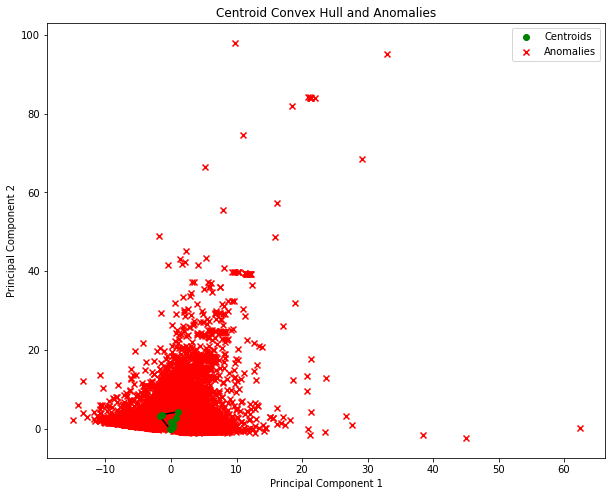

AttributeError: 'ConvexHull' object has no attribute 'find_simplex'

In [10]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# 质心凸包
centroid_hull = ConvexHull(centroids[['PC1', 'PC2']])

# 绘制质心和凸包
plt.figure(figsize=(10, 8))
for simplex in centroid_hull.simplices:
    plt.plot(centroids.iloc[simplex, 0], centroids.iloc[simplex, 1], 'k-')

# 显示异常点和质心
plt.scatter(centroids['PC1'], centroids['PC2'], color='green', zorder=10, label='Centroids')
plt.scatter(anomalies['PC1'], anomalies['PC2'], color='red', marker='x', label='Anomalies')

plt.title('Centroid Convex Hull and Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# 计算异常点在凸包内外的数量
inside = outside = 0
for index, anomaly in anomalies.iterrows():
    if centroid_hull.find_simplex(anomaly[['PC1', 'PC2']]) >= 0:
        inside += 1
    else:
        outside += 1

print(f"Anomalies inside the hull: {inside}")
print(f"Anomalies outside the hull: {outside}")


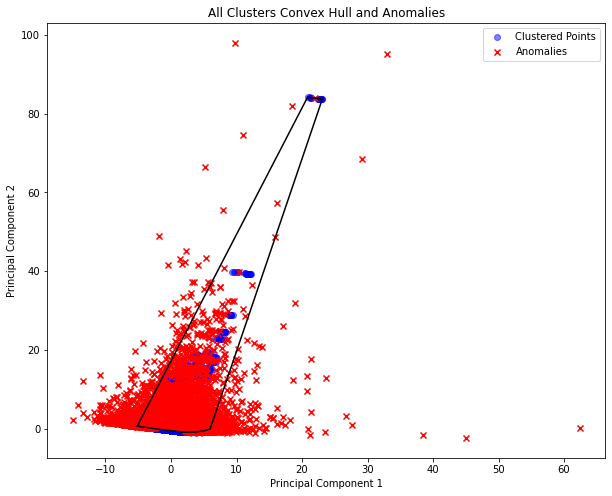

In [12]:
# 所有属于簇的点
cluster_points = pca_df[pca_df['Cluster'] != -1]

# 凸包
all_hull = ConvexHull(cluster_points[['PC1', 'PC2']])

# 绘制所有点的凸包
plt.figure(figsize=(10, 8))
for simplex in all_hull.simplices:
    plt.plot(cluster_points.iloc[simplex, 0], cluster_points.iloc[simplex, 1], 'k-')

# 显示异常点和聚类点
plt.scatter(cluster_points['PC1'], cluster_points['PC2'], color='blue', alpha=0.5, label='Clustered Points')
plt.scatter(anomalies['PC1'], anomalies['PC2'], color='red', marker='x', label='Anomalies')

plt.title('All Clusters Convex Hull and Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [14]:
# 筛选出所有异常点及其对应的字段
anomalies = data.loc[data['Cluster'] == -1, ['Date', 'Ticker', 'Adj Close']]

# 重新设置索引
anomalies.reset_index(inplace=True, drop=True)

# 导出到CSV
anomalies.to_csv('/Users/lyndseyxia/Desktop/NYU/capstone/fall/anomalies.csv', index=False)  # 确保路径是可写的

# 打印输出路径以确认文件保存位置
print('Anomalies CSV saved:', '/Users/lyndseyxia/Desktop/NYU/capstone/fall/anomalies.csv')


KeyError: "['Date'] not in index"